In [ ]:
# Importar las librerías necesarias
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Definir rutas de las carpetas con las imágenes de Parkinson y Control
ruta_pd = "/home/crakerool/Parkinson UCN/Parkinson/trainDatasets/PD"
ruta_control = "/home/crakerool/Parkinson UCN/Parkinson/trainDatasets/CONTROL"
ruta_gan_pd = "/home/crakerool/Parkinson UCN/Parkinson/ganGenerated/PD"
ruta_gan_control = "/home/crakerool/Parkinson UCN/Parkinson/ganGenerated/CONTROL"

# Crear carpetas para almacenar las imágenes generadas por el GAN, si no existen
os.makedirs(ruta_gan_pd, exist_ok=True)
os.makedirs(ruta_gan_control, exist_ok=True)

# Cargar las imágenes de las carpetas y convertirlas a matrices numpy
def cargar_imagenes(ruta, tamano=(64, 64)):
    imagenes = []
    for archivo in os.listdir(ruta):
        if archivo.endswith(".png"):
            ruta_img = os.path.join(ruta, archivo)
            img = Image.open(ruta_img).convert('RGB')
            img = img.resize(tamano)
            imagenes.append(np.array(img))
    return np.array(imagenes)

# Cargar las imágenes de Parkinson y normalizarlas
imagenes_pd = cargar_imagenes(ruta_pd)
imagenes_pd = (imagenes_pd - 127.5) / 127.5  # Normalizar las imágenes al rango [-1, 1]

# Definir parámetros del dataset de Parkinson
tamano_buffer_pd = imagenes_pd.shape[0]
tamano_lote = 32

# Crear dataset de TensorFlow para Parkinson
dataset_pd = tf.data.Dataset.from_tensor_slices(imagenes_pd).shuffle(tamano_buffer_pd).batch(tamano_lote)

# Cargar las imágenes de Control y normalizarlas
imagenes_control = cargar_imagenes(ruta_control)
imagenes_control = (imagenes_control - 127.5) / 127.5  # Normalizar las imágenes al rango [-1, 1]

# Definir parámetros del dataset de Control
tamano_buffer_control = imagenes_control.shape[0]

# Crear dataset de TensorFlow para Control
dataset_control = tf.data.Dataset.from_tensor_slices(imagenes_control).shuffle(tamano_buffer_control).batch(tamano_lote)

# Definir el generador del GAN
def construir_generador():
    modelo = Sequential()
    modelo.add(Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())

    modelo.add(Reshape((8, 8, 256)))
    modelo.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())

    modelo.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())

    modelo.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return modelo

# Definir el discriminador del GAN
def construir_discriminador():
    modelo = Sequential()
    modelo.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    modelo.add(LeakyReLU())
    modelo.add(tf.keras.layers.Dropout(0.3))

    modelo.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    modelo.add(LeakyReLU())
    modelo.add(tf.keras.layers.Dropout(0.3))

    modelo.add(Flatten())
    modelo.add(Dense(1))
    return modelo

# Crear los modelos del generador y el discriminador
generador = construir_generador()
discriminador = construir_discriminador()

# Definir la función de pérdida y los optimizadores
entropia_cruzada = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def perdida_generador(salida_falsa):
    return entropia_cruzada(tf.ones_like(salida_falsa), salida_falsa)

def perdida_discriminador(salida_real, salida_falsa):
    perdida_real = entropia_cruzada(tf.ones_like(salida_real), salida_real)
    perdida_falsa = entropia_cruzada(tf.zeros_like(salida_falsa), salida_falsa)
    return perdida_real + perdida_falsa

# Definir los optimizadores del generador y el discriminador
optimizador_generador = tf.keras.optimizers.Adam(1e-4)
optimizador_discriminador = tf.keras.optimizers.Adam(1e-4)

# Definir el entrenamiento del GAN
epocas = 100
dim_ruido = 100
num_imagenes_generar = 5

semilla = tf.random.normal([num_imagenes_generar, dim_ruido])

# Funciones para entrenar el GAN
@tf.function
def paso_entrenamiento(imagenes):
    ruido = tf.random.normal([tamano_lote, dim_ruido])

    with tf.GradientTape() as cinta_gen, tf.GradientTape() as cinta_disc:
        imagenes_generadas = generador(ruido, training=True)

        salida_real = discriminador(imagenes, training=True)
        salida_falsa = discriminador(imagenes_generadas, training=True)

        perdida_gen = perdida_generador(salida_falsa)
        perdida_disc = perdida_discriminador(salida_real, salida_falsa)

    gradientes_generador = cinta_gen.gradient(perdida_gen, generador.trainable_variables)
    gradientes_discriminador = cinta_disc.gradient(perdida_disc, discriminador.trainable_variables)

    optimizador_generador.apply_gradients(zip(gradientes_generador, generador.trainable_variables))
    optimizador_discriminador.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

def entrenar_gan(dataset, epocas, ruta_guardado):
    for epoca in range(epocas):
        for lote_imagenes in dataset:
            paso_entrenamiento(lote_imagenes)

        # Generar y guardar algunas imágenes al final de cada época
        generar_guardar_imagenes(generador, epoca + 1, semilla, ruta_guardado)
        print(f"Epoca {epoca + 1}/{epocas} completada")

# Funciones para generar y guardar imágenes
def generar_guardar_imagenes(modelo, epoca, entrada_prueba, ruta_guardado):
    predicciones = modelo(entrada_prueba, training=False)

    for i in range(predicciones.shape[0]):
        img = (predicciones[i] + 1) / 2  # Desnormalizar al rango [0, 1]
        img = tf.cast(img * 255, tf.uint8).numpy()  # Convertir a uint8
        img = Image.fromarray(img)
        img.save(os.path.join(ruta_guardado, f"gan_generado_epoca_{epoca}_img_{i}.png"))

# Generar 2000 imágenes adicionales con el GAN
num_imagenes_a_generar = 2000
ruido_adicional = tf.random.normal([num_imagenes_a_generar, dim_ruido])
imagenes_generadas_adicionales = generador(ruido_adicional, training=False)
imagenes_generadas_adicionales = (imagenes_generadas_adicionales + 1) / 2  # Desnormalizar al rango [0, 1]

# Guardar las imágenes generadas y agregarlas al entrenamiento de la CNN
for i in range(num_imagenes_a_generar):
    img = tf.cast(imagenes_generadas_adicionales[i] * 255, tf.uint8).numpy()
    img = Image.fromarray(img)
    img.save(os.path.join(ruta_gan_pd, f"gan_imagen_adicional_{i}.png"))

# Entrenar el GAN con imágenes de Parkinson
print("Entrenando GAN con imágenes de Parkinson...")
entrenar_gan(dataset_pd, epocas, ruta_gan_pd)

# Entrenar el GAN con imágenes de Control
print("Entrenando GAN con imágenes de Control...")
entrenar_gan(dataset_control, epocas, ruta_gan_control)

# Definición del modelo CNN
modelo_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilación del modelo
modelo_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Cargar y preparar las imágenes para el entrenamiento y validación de la CNN
generador_datos = ImageDataGenerator(rescale=1.0/255, validation_split=0.01)

generador_entrenamiento = generador_datos.flow_from_directory(
    '/home/crakerool/Parkinson UCN/Parkinson/trainDatasets',
    classes=['PD', 'CONTROL'],
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    subset='training'
)

generador_validacion = generador_datos.flow_from_directory(
    '/home/crakerool/Parkinson UCN/Parkinson/trainDatasets',
    classes=['PD', 'CONTROL'],
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Entrenamiento del modelo CNN
historia = modelo_cnn.fit(
    generador_entrenamiento,
    steps_per_epoch=len(generador_entrenamiento),
    epochs=15,
    validation_data=generador_validacion,
    validation_steps=len(generador_validacion)
)


2024-11-11 15:44:13.232328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-11 15:44:21.605782: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Entrenando GAN con imágenes de Parkinson...


2024-11-11 15:44:32.603958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [4530,64,64,3]
	 [[{{node Placeholder/_0}}]]
2024-11-11 15:44:32.604177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [4530,64,64,3]
	 [[{{node Placeholder/_0}}]]


Epoca 1/100 completada
Epoca 2/100 completada
Epoca 3/100 completada
Epoca 4/100 completada
Epoca 5/100 completada
Epoca 6/100 completada
Epoca 7/100 completada
Epoca 8/100 completada
Epoca 9/100 completada
Epoca 10/100 completada
Epoca 11/100 completada
Epoca 12/100 completada
Epoca 13/100 completada
Epoca 14/100 completada
Epoca 15/100 completada
Epoca 16/100 completada
Epoca 17/100 completada
Epoca 18/100 completada
Epoca 19/100 completada
Epoca 20/100 completada
Epoca 21/100 completada
Epoca 22/100 completada
Epoca 23/100 completada
Epoca 24/100 completada
Epoca 25/100 completada
Epoca 26/100 completada
Epoca 27/100 completada
Epoca 28/100 completada
Epoca 29/100 completada
Epoca 30/100 completada
Epoca 31/100 completada
Epoca 32/100 completada
Epoca 33/100 completada
Epoca 34/100 completada
Epoca 35/100 completada
Epoca 36/100 completada
Epoca 37/100 completada
Epoca 38/100 completada
Epoca 39/100 completada
Epoca 40/100 completada
Epoca 41/100 completada
Epoca 42/100 completada
E

2024-11-11 16:37:33.703752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [6020,64,64,3]
	 [[{{node Placeholder/_0}}]]
2024-11-11 16:37:33.704043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [6020,64,64,3]
	 [[{{node Placeholder/_0}}]]


Epoca 1/100 completada
Epoca 2/100 completada
Epoca 3/100 completada
Epoca 4/100 completada
Epoca 5/100 completada
Epoca 6/100 completada
Epoca 7/100 completada
Epoca 8/100 completada
Epoca 9/100 completada
Epoca 10/100 completada
Epoca 11/100 completada
Epoca 12/100 completada
Epoca 13/100 completada
Epoca 14/100 completada
Epoca 15/100 completada
Epoca 16/100 completada
Epoca 17/100 completada
Epoca 18/100 completada
Epoca 19/100 completada
Epoca 20/100 completada
Epoca 21/100 completada
Epoca 22/100 completada
Epoca 23/100 completada
Epoca 24/100 completada
Epoca 25/100 completada
Epoca 26/100 completada
Epoca 27/100 completada
Epoca 28/100 completada
Epoca 29/100 completada
Epoca 30/100 completada
Epoca 31/100 completada
Epoca 32/100 completada
Epoca 33/100 completada
Epoca 34/100 completada
Epoca 35/100 completada
Epoca 36/100 completada
Epoca 37/100 completada
Epoca 38/100 completada
Epoca 39/100 completada
Epoca 40/100 completada
Epoca 41/100 completada
Epoca 42/100 completada
E

2024-11-11 17:45:07.231783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


653/653 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.9104

2024-11-11 17:47:12.905601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


653/653 [==============================] - 126s 192ms/step - loss: 0.2224 - accuracy: 0.9104 - val_loss: 0.2230 - val_accuracy: 0.9238
Epoch 2/15
653/653 [==============================] - 110s 168ms/step - loss: 0.1856 - accuracy: 0.9192 - val_loss: 0.2400 - val_accuracy: 0.9238
Epoch 3/15
653/653 [==============================] - 118s 181ms/step - loss: 0.1388 - accuracy: 0.9393 - val_loss: 0.2056 - val_accuracy: 0.8952
Epoch 4/15
653/653 [==============================] - 109s 166ms/step - loss: 0.0742 - accuracy: 0.9707 - val_loss: 0.2482 - val_accuracy: 0.8952
Epoch 5/15
653/653 [==============================] - 125s 191ms/step - loss: 0.0397 - accuracy: 0.9850 - val_loss: 0.3968 - val_accuracy: 0.8667
Epoch 6/15
653/653 [==============================] - 121s 186ms/step - loss: 0.0214 - accuracy: 0.9920 - val_loss: 0.6032 - val_accuracy: 0.9143
Epoch 7/15
653/653 [==============================] - 108s 165ms/step - loss: 0.0142 - accuracy: 0.9952 - val_loss: 0.5431 - val_accura

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.layers import Dense, Reshape, Flatten, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

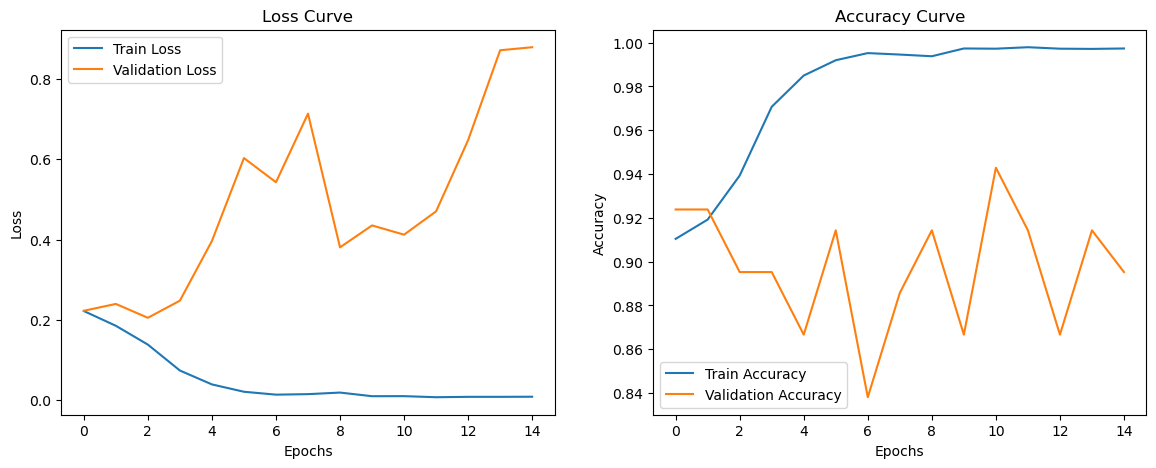

1/4 [======>.......................] - ETA: 0s

2024-11-11 20:22:16.905598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 0s 68ms/step


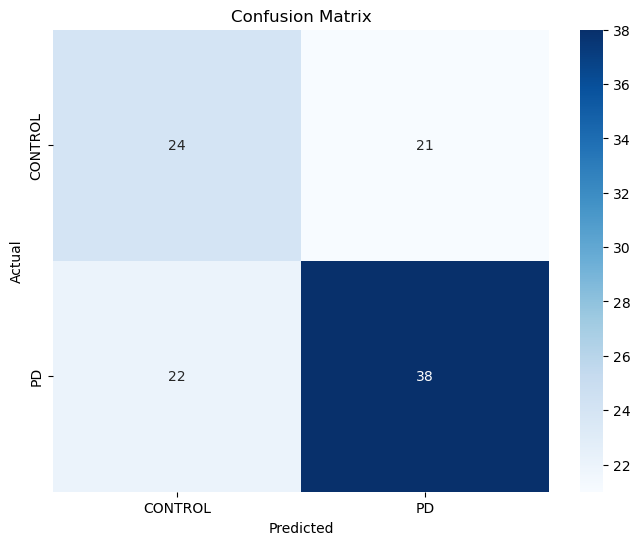

1/4 [======>.......................] - ETA: 0s

2024-11-11 20:22:17.522049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 0s 72ms/step


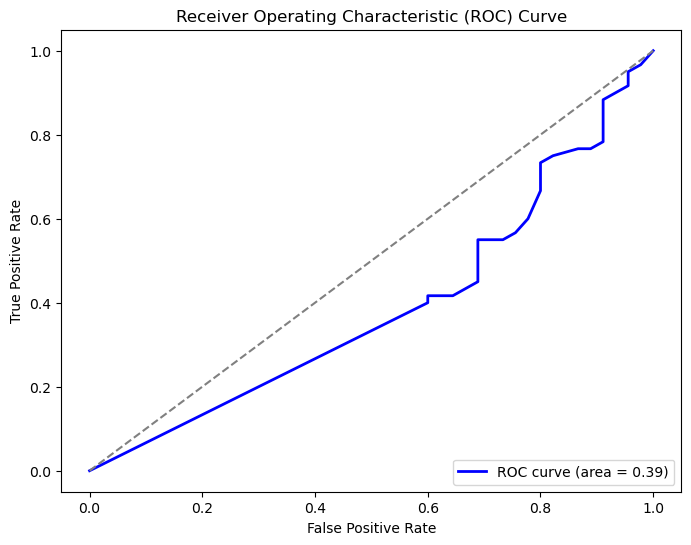

2/4 [==============>...............] - ETA: 0s

2024-11-11 20:22:18.099441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 0s 80ms/step


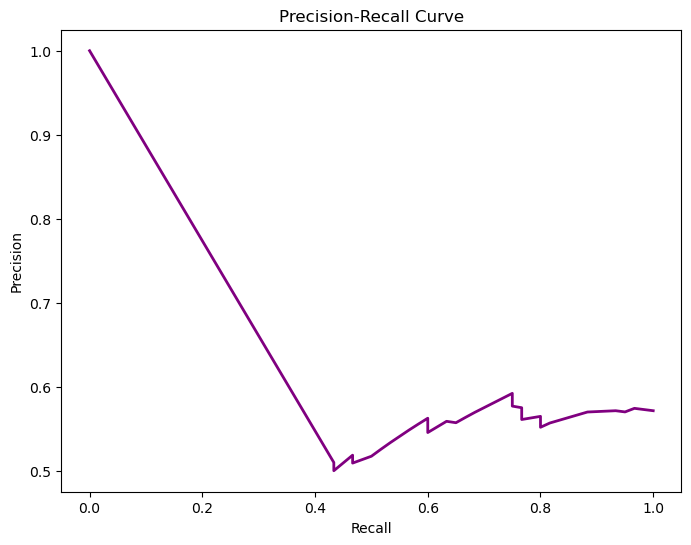

NameError: name 'perdidas_generador_pd' is not defined

In [ ]:
# 1. Curva de Pérdida y Precisión para la CNN
def plot_loss_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Curva de pérdida
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()

    # Curva de precisión
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Curve')
    ax2.legend()

    plt.show()

# 2. Matriz de Confusión
def plot_confusion_matrix(model, validation_generator):
    validation_generator.reset()
    Y_pred = model.predict(validation_generator, steps=len(validation_generator))
    y_pred = np.round(Y_pred).astype(int)
    cm = confusion_matrix(validation_generator.classes, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CONTROL', 'PD'], yticklabels=['CONTROL', 'PD'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# 3. Curva ROC y AUC
def plot_roc_curve(model, validation_generator):
    validation_generator.reset()
    Y_pred = model.predict(validation_generator, steps=len(validation_generator))
    fpr, tpr, _ = roc_curve(validation_generator.classes, Y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# 4. Curva de Precisión-Recall
def plot_precision_recall_curve(model, validation_generator):
    validation_generator.reset()
    Y_pred = model.predict(validation_generator, steps=len(validation_generator))
    precision, recall, _ = precision_recall_curve(validation_generator.classes, Y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='purple', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# 5. Visualización de Imágenes Generadas por GAN
def plot_generated_images(generator, epoch, num_examples=5):
    noise = tf.random.normal([num_examples, dim_ruido])
    generated_images = generator(noise, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i+1)
        plt.imshow((generated_images[i] + 1) / 2)
        plt.axis('off')
    plt.suptitle(f'Generated Images at Epoch {epoch}')
    plt.show()

# 6. Gráficas para el GAN: Pérdida del Generador y Discriminador
def plot_gan_losses(generator_losses, discriminator_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('GAN Losses')
    plt.legend()
    plt.show()

# Ejecutar las funciones de visualización de métricas
plot_loss_accuracy(historia)
plot_confusion_matrix(modelo_cnn, generador_validacion)
plot_roc_curve(modelo_cnn, generador_validacion)
plot_precision_recall_curve(modelo_cnn, generador_validacion)
plot_gan_losses(perdidas_generador_pd, perdidas_discriminador_pd)
plot_generated_images(generador, epoch=epocas)
